# Objectives:
    
    1. Build a PySpark machine learning model  (logistic regression model) using EMR (Elastic MapReduce) notebook
    on AWS (Amazon Web Services).
    
    2. Perform feature engineering and balance the Amazon customer reviews dataset.
    
    3. Build a pipeline to perform different tasks in feature engineering such as Tokenizing and OneHot Encoding.
    
    4. Finding the Optimal parameters (regParam and elasticNetParam) for the machine learning model using 3-fold   cross-validated grid search on an EMR cluster with 8m5.xlarge EC2 instances.
    

In [1]:
# EMR (Elastic MapReduce) notebook to run PySpark framework on AWS

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1591325508555_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Setting up the notebook and preparing the dataset

**Dataset: Amazon Customer Reviews/Product Reviews**
    
It features million reviews for different products sold on Amazon marketplace. The reviews that have been contributed by millions of buyers expresses their opinions and experiences about the product’s quality, their buying experience, etc. The different variables in the dataset are: ‘customer_id’, ‘review_id’, ‘product_id’, ‘star_rating’, ‘total_votes’, ‘vine’, ‘verified_purchase’ and ‘review_date’ among others.

**Load Amazon Customer Reviews Dataset**

In [2]:
%%bash
aws s3 ls s3://amazon-reviews-pds/parquet/product_category=Books/ --summarize --human-readable

2018-04-09 06:35:58    1.0 GiB part-00000-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:35:59    1.0 GiB part-00001-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:00    1.0 GiB part-00002-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:00    1.0 GiB part-00003-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:00    1.0 GiB part-00004-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:33    1.0 GiB part-00005-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:35    1.0 GiB part-00006-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:35    1.0 GiB part-00007-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:35    1.0 GiB part-00008-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
2018-04-09 06:36:35    1.0 GiB part-00009-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet

Total Obj

**Install packages in PySpark framework**

In [3]:
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/c7/e6/54aaaafd0b87f51dfba92ba73da94151aa3bc179e5fe88fc5dfb3038e860/seaborn-0.10.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/5f/1b6e0efab4bfb738478919d40b0e3e1a06e3d9996da45eb62a77e9a090d9/pandas-1.0.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached 

**Importing packages and reading the dataset**

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Dropping NA values and creating a categorical variable (binary) for good/bad reviews**

In [6]:
data=data.dropna('any')

# Good == 1, Bad == 0 (cast as integers so that pyspark.ml can understand them)
data = data.withColumn('good_review', (data.star_rating >= 4).cast("integer"))

# Check to make sure new column is capturing star_rating correctly
data[['star_rating', 'good_review']].show(5)

# Take a look at how many good and bad reviews we have, respectively
(data.groupBy('good_review')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+
|star_rating|good_review|
+-----------+-----------+
|          5|          1|
|          4|          1|
|          4|          1|
|          5|          1|
|          5|          1|
+-----------+-----------+
only showing top 5 rows

+-----------+--------+
|good_review|   count|
+-----------+--------+
|          1|17208252|
|          0| 3517653|
+-----------+--------+

# 1. Visualising Feature Importance

In [7]:
#question 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

*Feature Engineering part is presented with Question 3. Below, I have attached table/plots depicting feature importance:*

**Helpful votes is a numerical variable and below one can observe the variation in number of good reviews with the number of helpful votes.**

In [8]:
(data.groupBy('good_review', 'helpful_votes').count().show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------+-------+
|good_review|helpful_votes|  count|
+-----------+-------------+-------+
|          0|           57|   1382|
|          0|          145|    103|
|          1|          204|     89|
|          0|          243|     31|
|          1|          213|     77|
|          0|          261|     24|
|          1|           20|  33969|
|          0|           48|   2228|
|          0|           14|  32261|
|          0|          246|     27|
|          0|          133|    167|
|          1|            9| 159286|
|          0|            5| 147887|
|          0|           90|    408|
|          0|          850|      1|
|          1|            1|3232853|
|          1|          175|    158|
|          1|           97|    700|
|          0|          812|      2|
|          0|         1209|      1|
+-----------+-------------+-------+
only showing top 20 rows

**Next numerical variable is 'year'. The plot shows the varying trend in the number of good reviews across different years. The recent jump in the number of good reviews shows its relevance for the model.**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

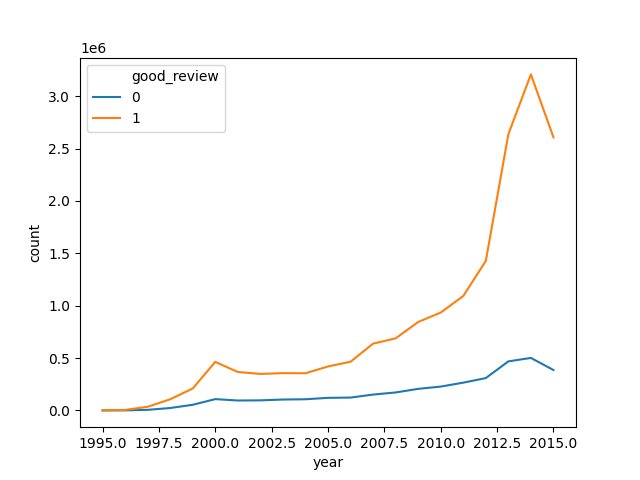

In [9]:
plt.close()
data_yr = (data.groupBy('good_review', 'year').count()).toPandas()
sns.lineplot(x='year',y='count', hue='good_review',data = data_yr)
%matplot plt 

In [10]:
(data.groupBy('good_review', 'verified_purchase').count().show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------------+-------+
|good_review|verified_purchase|  count|
+-----------+-----------------+-------+
|          0|                Y|1488413|
|          0|                N|2029240|
|          1|                N|8106766|
|          1|                Y|9101486|
+-----------+-----------------+-------+

**'verified_purchase' is a categorical variable, and it would be interesting to find its effect in the model. Intuitively, verified  purchases should have a positive impact on the number of good reviews.**

In [11]:
(data.groupBy('good_review', 'product_title').count().orderBy('product_title').show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+-----+
|good_review|       product_title|count|
+-----------+--------------------+-----+
|          1|!!! A Fine Collec...|    3|
|          1|!!Dale a LA Grama...|    1|
|          1|!!Dale a LA Grama...|    1|
|          1|!!Vamos Al Circo!...|    1|
|          0|!!Vamos!: Vamos -...|    1|
|          1|!%@:: A Directory...|    1|
|          1|!Amigas Forever! ...|    1|
|          1|!Arriba! A First ...|    1|
|          1|!Asi! 1 Students'...|    1|
|          1|!Avancemos! Teach...|    1|
|          1|!Buen viaje! Leve...|    2|
|          1|!Buen viaje! Leve...|    1|
|          1|!Buen viaje!, Cou...|    2|
|          0|!Che Boludo! A gr...|    1|
|          1|!Che Boludo! A gr...|    7|
|          1|!En Espanol! Unit...|    1|
|          1|!Expresate! (Holt...|    2|
|          1|!Fish! La Eficaci...|    3|
|          0|!He Muerto!: Biog...|    2|
|          1|!He Muerto!: Biog...|    1|
+-----------+--------------------+-----+
only showing top

**I am using 'product_title' as text feature in my model. Using different stages: tokenizer, remover, hasher and IDF, I will convert it into a numerical feature. I do not have any experience in NLP but looking at the table above, there's variation in the number of good reviews across titles and I believe it will contribute to our model.**


# 2. Balancing the data

In [12]:
#question 2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Downsampled the data using 'sampleBy' function. As seen in the table below, the new dataset has balanced number of good and bad reviews.**

In [13]:
from pyspark.sql.functions import col

ratio = 3517653/17208252
sample = data.sampleBy("good_review", fractions={0: 1, 1: ratio}, seed=0)
sample.groupBy("good_review").count().orderBy("good_review").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+
|good_review|  count|
+-----------+-------+
|          0|3517653|
|          1|3516830|
+-----------+-------+

# 3. Feature Engineering and Implementing a pipeline

In [14]:
# question 3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Feature engineering: 'product_title'**

In [15]:

# Break text into tokens at non-word characters
tokenizer = Tokenizer(inputCol="product_title", outputCol="tokens")
# Remove stop words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='words')
# Apply the hashing trick and transform to TF-IDF
hasher = HashingTF(inputCol=remover.getOutputCol(), outputCol="hash", numFeatures=32)
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="text_feature")

# feature engineering: 'verified_purchase'

indexer = StringIndexer(inputCol='verified_purchase', outputCol='vp_idx')
onehot = OneHotEncoderEstimator(inputCols=['vp_idx'], outputCols=['vp_dummy'])

# feature engineering: Not required for 'year' and 'helpful_votes'


assembler = VectorAssembler(inputCols = ['total_votes', 'text_feature', 'year', 'helpful_votes', 'vp_dummy'],\
                            outputCol = 'features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Building a pipeline**

In [16]:

pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf, indexer, onehot, assembler])
pipeline = pipeline.fit(sample)
sample = pipeline.transform(sample)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Question: (Under the hood) Is the DataFrame actually processed when one chains together a sequence of transformations in  a  pipeline?**

**No, the dataframe is not processed when transformations are chained together in a pipeline. It can be thought of as a formula/rule with instructions/stages (to be carried when called out later). When we either 'transform' or 'fit' our data, PySpark performs the actual transformations.**

# 4. Finding the Optimal Model Parameters

In [23]:
#question 4

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Parameter optimization using grid search on an EMR cluster with 8m5.xlarge EC2 instances**

In [27]:
train, test = sample.randomSplit([0.7, 0.3])

# Create a logistic regression object and add everything to a pipeline
logistic = LogisticRegression(featuresCol='features', labelCol='good_review')

# Create parameter grid
params = ParamGridBuilder()

# Add grids for two parameters
params = params.addGrid(logistic.regParam, np.arange(0,0.1,0.01)) \
               .addGrid(logistic.elasticNetParam, [0,1])

# Build the parameter grid
params = params.build()
print('Number of models to be tested: ', len(params))

evaluator = BinaryClassificationEvaluator(labelCol='good_review', metricName='areaUnderROC')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of models to be tested:  20

**Creating a cross-validator**

In [28]:

cv = CrossValidator(estimator=logistic, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=0)

cv = cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-27:
Traceback (most recent call last):
  File "/emr/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/emr/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/emr/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1268



**Extracting paramter values of the best model**

In [29]:
best_model = cv.bestModel
print('best_model:', best_model.extractParamMap())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

best_model: {Param(parent='LogisticRegression_36d9e4a9bafc', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_36d9e4a9bafc', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_36d9e4a9bafc', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_36d9e4a9bafc', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_36d9e4a9bafc', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_36d9e4a9bafc', name='labelCol', doc='label column name'): 'good_review', Param(parent='LogisticRegression_36d9e4a9bafc', name='maxIter', doc='maximum number of iteration

**Summary of the test results for the best logistic regression model**

In [30]:
# Training Summary Data
trainingSummary = best_model.summary
evaluationSummary = best_model.evaluate(test)

print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6889762906547136
Test AUC:  0.6888368937700725

False positive rate by label (Training):
label 0: 0.181458504599408
label 1: 0.5223391952590974

True positive rate by label (Training):
label 0: 0.47766080474090256
label 1: 0.8185414954005921

Training Accuracy: 0.6481388870494587
Test Accuracy:  0.648114267798458

**Plotting the ROC curve (Receiver Operating Characteristic curve)**

In [31]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

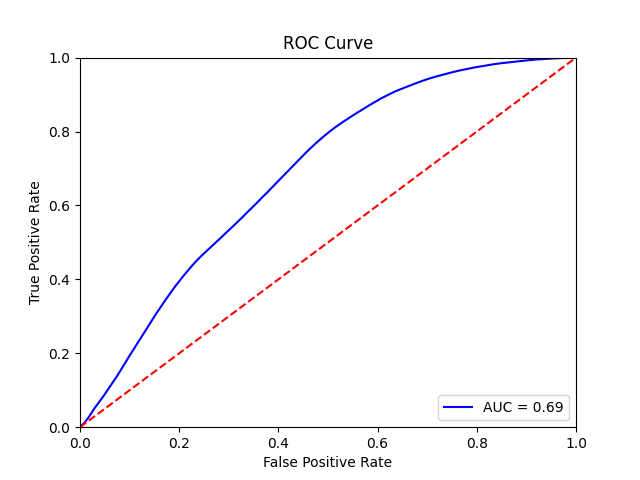

In [32]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

**Best model with regParam equal to 0, and elasticNetParam equal to 1. As seen above, model works well in identifying label 1, the true positive rate for label 1 is high, around 81 %. However, the model is bad with identifying false positives for label 1 and true positive rates for label 0, both of which are around 50%.**

# 5. Scaling up using larger number of m5.xlarge instances

In [ ]:
#question 5

**The time to run ML algorithm over AWS using Spark framework and EMR, reduces linearly with an increase in number of m5.xlarge instances. For example, the run time reduced from 44 minutes to around 35 minutes when the number of m5.xlarge instances were icreased from 4 to 6. The running time further reduced from 35 minnutes to 18 when the number of m5.xlarge instances were incrased from 6 to 8. Overall, there was 60% reduction in running time when the number of instances were doubled from 4 to 8.**

Note: These running times were calculated for the downsampled data. Here, I first randomly sampled data with frequency 0.20, and then created a balanced subset of good and bad reviews. Moreover, for cross-validation the number of folds were reduced from 5 (original value) to 3 (minimum number of folds allowed). In my opinion, even with subsetting of data and reduced number of folds, the linear dependence of running time over number of m5.xlarge instances is still highlighted as shown in the table below:


| Number of m5.xlarge instances | Time (in seconds) |  Approx. Time (in minutes) |
| --- | ----------- | ----------- |
|8 | 1079.13 | 18 |
|6 | 2107.34 | 35 |
|4 | 2605.28 | 44 |


Spark framework successfully reads the data from AWS S3 and distributes the computing across a large number of clusters. To speed up ML algorithms, we use AWS EMR (ElasticMapReduce) service to launch clusters with multiple instances, that parallelizes ML algorithms effectively. For example, m5.xlarge provides access to 4 vCPUs with 16GIB memory each. Hence, with 8 such instances, we get access to 32 vCPUs, each with 16 GIB memory. This large memory bandwidth alongwith Spark helps in caching data in the memory for larger datasets unlike other clusters.

Spark framework efficiently caches datasets in memory, as needed: For ML algorithms like logistic regression we require multiple iterations/passes over the data, so data cached in memory helps in scaling up the running time of the algorithm. Additionally, the pipeline feature of Spark optimizes the distribution of tasks over nodes as it delays any calculation until called for evaluation. Therefore, synchronization of nodes on EMR cluster along with Spark architecture helps remove bottlenecks like caching data in memory, etc. that are often witnessed while scaling up ML algorithms over large scale datasets.

